In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('processed_data/team_games_features.csv')

### Start exploring the data

### On average, do away teams lose more than home teams?

In [156]:
g = df.copy()

grouped = g.groupby('is_away')['game_result'].apply(lambda s: (s == 'win').mean())
display(grouped)


is_away
False    0.5625
True     0.4375
Name: game_result, dtype: float64

### Distance traveled by team

Index(['Unnamed: 0', 'game_id', 'season', 'game_date', 'game_type', 'venue',
       'venue_utc_offest', 'home_team_id', 'away_team_id', 'home_team_abbrev',
       'away_team_abbrev', 'home_team_score', 'away_team_score',
       'start_time_utc', 'winner_abbrev', 'loser_abbrev', 'goal_diff',
       'venue_team', 'League', 'Division', 'venue_lat', 'venue_lon', 'team',
       'goals_for', 'goals_against', 'is_away', 'game_result',
       'goal_difference', 'venue_lat_prev', 'venue_lon_prev', 'distance',
       'consecutive_away_games', 'rest_days', 'back_to_back'],
      dtype='object')


,Unnamed: 0,game_id,season,game_date,game_type,venue,venue_utc_offest,home_team_id,away_team_id,home_team_abbrev,...,goals_against,is_away,game_result,goal_difference,venue_lat_prev,venue_lon_prev,distance,consecutive_away_games,rest_days,back_to_back
0,1312,2024020037,20242025,2024-10-12,2,SAP Center at San Jose,-07:00,28,24,SJS,...,0.0,True,win,2.0,37.332778,-121.901111,0.000000,1,0.0,True
1,1313,2024020041,20242025,2024-10-13,2,T-Mobile Arena,-07:00,54,24,VGK,...,3.0,True,loss,-2.0,37.332778,-121.901111,614.480367,2,0.0,True
2,2,2024020060,20242025,2024-10-16,2,Honda Center,-07:00,24,59,ANA,...,4.0,False,win,1.0,36.102778,-115.178333,354.362774,0,2.0,False
3,1315,2024020074,20242025,2024-10-18,2,Ball Arena,-06:00,21,24,COL,...,4.0,True,loss,-1.0,33.807778,-117.876667,1320.953946,3,1.0,False
4,4,2024020090,20242025,2024-10-20,2,Honda Center,-07:00,24,26,ANA,...,4.0,False,loss,-3.0,39.748700,-105.007600,1320.953946,0,1.0,False


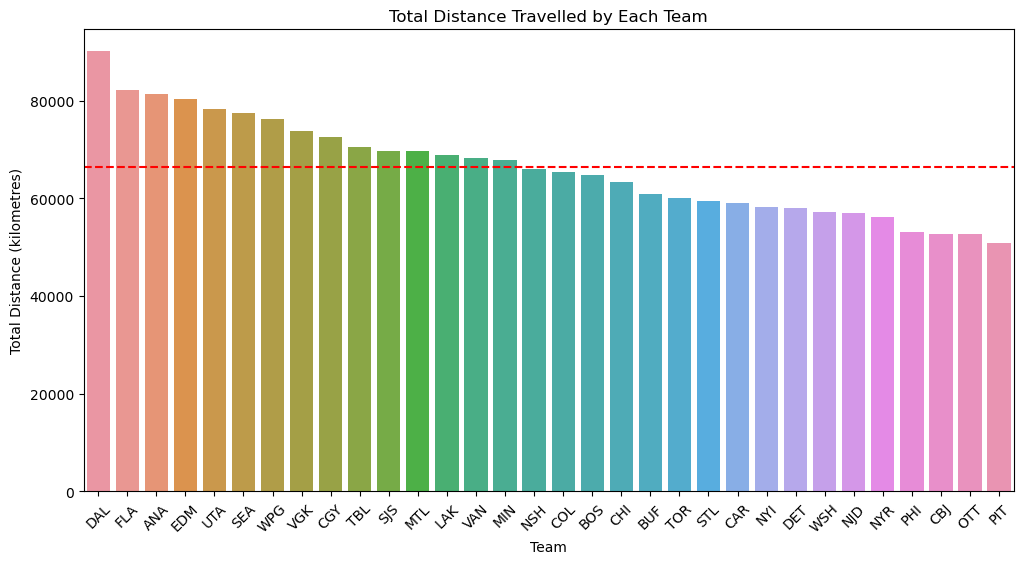

In [166]:
print(df.columns)
display(df.head())

# df = df[df['is_away']]
grouped = df.groupby('team')['distance'].sum()
grouped = grouped.sort_values(ascending=False)
# create a graph for the data (include average line)
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped.index, y=grouped.values)
plt.title('Total Distance Travelled by Each Team')
plt.xlabel('Team')
plt.ylabel('Total Distance (kilometres)')
average_distance = grouped.mean()
plt.axhline(average_distance, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.show()


Some observations:

- It seems like the east coast teams in the metropolitan division travel the least

In [142]:
# create a mapping of teams and their respective conference

copy = df.copy()
copy['Conference'] = np.where(copy['Division'].isin(['Atlantic', 'Metropolitan']), 'East', 'West')
copy = copy[copy['home_team_abbrev'] == copy['team']]
copy = copy[['team', 'Conference']].drop_duplicates()

display(copy)

,team,Conference
2,ANA,West
83,BOS,East
164,BUF,East
246,CAR,East
330,CBJ,East
411,CGY,West
496,CHI,West
575,COL,West
657,DAL,West
738,DET,East


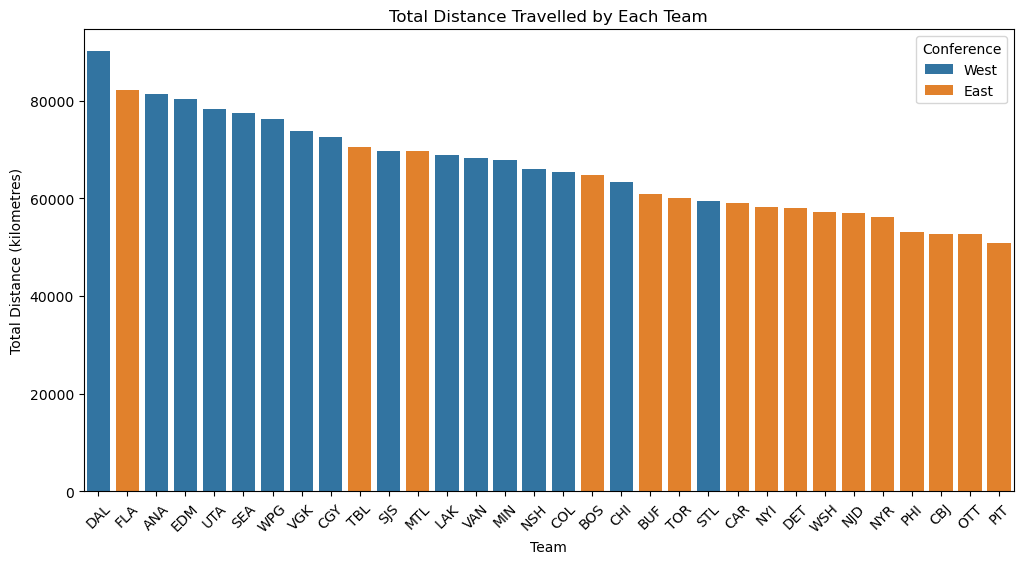

average total distance traveled by teams in the same conference:


Conference
East    60247.014854
West    72461.484993
Name: distance, dtype: float64

In [ ]:
conference_analysis_df = df.merge(copy, on='team', how='left')
# now do analysis
conference_group = conference_analysis_df.groupby(['team','Conference'])['distance'].sum().reset_index()
conference_group = conference_group.sort_values(by='distance', ascending=False)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(data=conference_group, x='team', y='distance', hue='Conference', dodge=False)
plt.title('Total Distance Travelled by Each Team')
plt.xlabel('Team')
plt.ylabel('Total Distance (kilometres)')
plt.xticks(rotation=45)
plt.legend(title='Conference')  # Ensures legend is shown and labeled
plt.show()

print('average total distance traveled by teams in the same conference:')
display(conference_group.groupby('Conference')['distance'].mean())


Finding: on average, an eastern team travel ~12,000 kilometres less than a western team in a single season (2024-2025)

Questions:

- is there a difference between travel times for east and west teams?

In [144]:
wins_analysis = df.copy()

wins_analysis = wins_analysis.groupby('game_result')['distance'].mean()
display(wins_analysis)

game_result
loss    822.076131
win     796.320209
Name: distance, dtype: float64

### Which team handled travel best? Total points / distance traveled

In [ ]:
standings_df = pd.read_csv('processed_data/nhl_standings_2025.csv')
standings_df = standings_df.rename(columns={"teamAbbrev.default": "team"})

team_points_df = standings_df[['team', 'points']].copy()
distance_df = grouped.reset_index()
# overall, did teams perform worse when they had more travel distance?

distances_and_points_df = distance_df.merge(team_points_df, on='team', how='left')
distances_and_points_df['points / distance'] = distances_and_points_df['points'] / distances_and_points_df['distance']
distances_and_points_df.sort_values(by='points / distance', ascending=False)
# normalize
display(distances_and_points_df)


ValueError: cannot insert level_0, already exists

### How did rest days effect the travelling team's win %?

0.0    292
1.0    704
2.0    238
3.0     42
4.0     14
5.0     22
Name: rest_clipped, dtype: int64

,Unnamed: 0,game_id,season,game_date,game_type,venue,venue_utc_offest,home_team_id,away_team_id,home_team_abbrev,...,is_away,game_result,goal_difference,venue_lat_prev,venue_lon_prev,distance,consecutive_away_games,rest_days,back_to_back,rest_clipped
0,1312,2024020037,20242025,2024-10-12,2,SAP Center at San Jose,-07:00,28,24,SJS,...,True,win,2.0,37.332778,-121.901111,0.000000,1,0.0,True,0.0
1,1313,2024020041,20242025,2024-10-13,2,T-Mobile Arena,-07:00,54,24,VGK,...,True,loss,-2.0,37.332778,-121.901111,614.480367,2,0.0,True,0.0
3,1315,2024020074,20242025,2024-10-18,2,Ball Arena,-06:00,21,24,COL,...,True,loss,-1.0,33.807778,-117.876667,1320.953946,3,1.0,False,1.0
6,1318,2024020128,20242025,2024-10-26,2,Madison Square Garden,-04:00,3,24,NYR,...,True,loss,-1.0,33.807778,-117.876667,3916.834737,4,3.0,False,3.0
7,1319,2024020137,20242025,2024-10-27,2,Prudential Center,-04:00,1,24,NJD,...,True,loss,-4.0,40.750556,-73.993611,15.072150,5,0.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616,1617,2024021193,20242025,2025-04-02,2,Lenovo Center,-04:00,12,15,CAR,...,True,loss,-4.0,42.366303,-71.062228,983.847300,37,0.0,True,0.0
2618,2383,2024021222,20242025,2025-04-06,2,UBS Arena,-04:00,2,15,NYI,...,True,loss,-3.0,38.898200,-77.020900,346.144210,38,1.0,False,1.0
2620,1690,2024021270,20242025,2025-04-12,2,Nationwide Arena,-04:00,29,15,CBJ,...,True,loss,-7.0,38.898200,-77.020900,527.527911,39,1.0,False,1.0
2622,2386,2024021296,20242025,2025-04-15,2,UBS Arena,-04:00,2,15,NYI,...,True,win,2.0,38.898200,-77.020900,346.144210,40,1.0,False,1.0


1312


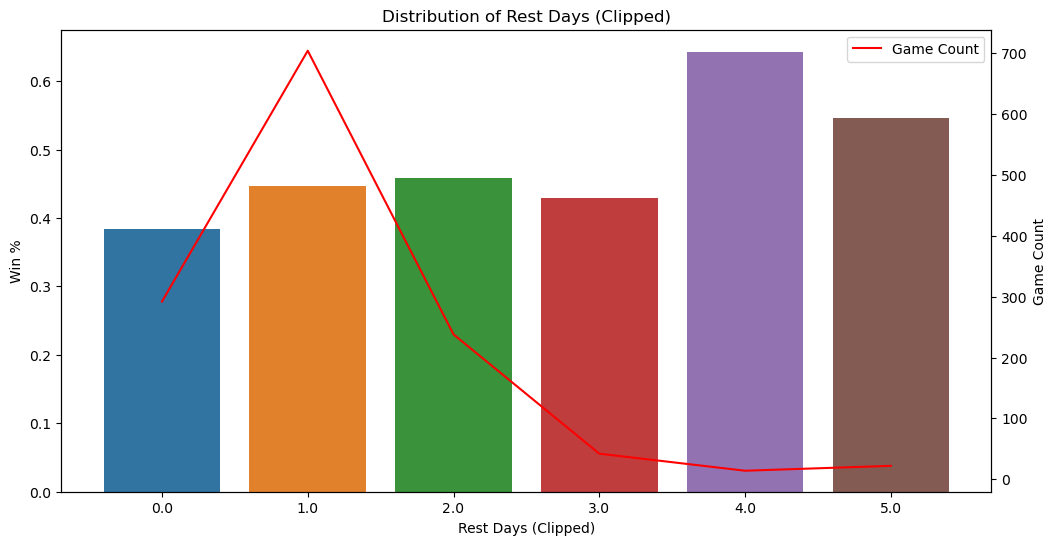

In [152]:
g = df.copy()
g = g[g['is_away']]
g['rest_clipped'] = g['rest_days'].clip(0,5) # exclude super long breaks (all-star week)
win_pct = g.groupby('rest_clipped')['game_result'].apply(lambda s:(s=='win').mean()) # gets the win percentage for each group

counts = g['rest_clipped'].value_counts().sort_index()
display(counts) # counts the number of games in each group
# g = g.sort_values()
display(g)

print(sum(counts))


# plot
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x=win_pct.index, y=win_pct.values, ax=ax1)
plt.title('Distribution of Rest Days (Clipped)')
plt.xlabel('Rest Days (Clipped)')
plt.ylabel('Win %')
ax2 = ax1.twinx()
sns.lineplot(x=counts.index, y=counts.values, color='red', label='Game Count', ax=ax2)
ax2.set_ylabel('Game Count')
plt.show()


0.0    138
1.0    791
2.0    279
3.0     63
4.0     21
5.0     20
Name: rest_clipped, dtype: int64

,Unnamed: 0,game_id,season,game_date,game_type,venue,venue_utc_offest,home_team_id,away_team_id,home_team_abbrev,...,is_away,game_result,goal_difference,venue_lat_prev,venue_lon_prev,distance,consecutive_away_games,rest_days,back_to_back,rest_clipped
2,2,2024020060,20242025,2024-10-16,2,Honda Center,-07:00,24,59,ANA,...,False,win,1.0,36.102778,-115.178333,354.362774,0,2.0,False,2.0
4,4,2024020090,20242025,2024-10-20,2,Honda Center,-07:00,24,26,ANA,...,False,loss,-3.0,39.748700,-105.007600,1320.953946,0,1.0,False,1.0
5,5,2024020105,20242025,2024-10-22,2,Honda Center,-07:00,24,28,ANA,...,False,win,2.0,33.807778,-117.876667,0.000000,0,1.0,False,1.0
10,10,2024020191,20242025,2024-11-03,2,Honda Center,-08:00,24,16,ANA,...,False,loss,-2.0,40.439444,-79.989167,3411.702902,0,2.0,False,2.0
11,11,2024020203,20242025,2024-11-05,2,Honda Center,-08:00,24,23,ANA,...,False,loss,-4.0,33.807778,-117.876667,0.000000,0,1.0,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,803,2024021110,20242025,2025-03-22,2,Capital One Arena,-04:00,15,13,WSH,...,False,win,3.0,38.898200,-77.020900,0.000000,0,1.0,False,1.0
2614,229,2024021171,20242025,2025-03-30,2,Capital One Arena,-04:00,15,7,WSH,...,False,loss,-3.0,44.944722,-93.101111,1487.014929,0,2.0,False,2.0
2617,514,2024021207,20242025,2025-04-04,2,Capital One Arena,-04:00,15,16,WSH,...,False,win,2.0,35.803333,-78.721944,375.526746,0,1.0,False,1.0
2619,307,2024021252,20242025,2025-04-10,2,Capital One Arena,-04:00,15,12,WSH,...,False,win,1.0,40.712094,-73.727157,346.144210,0,3.0,False,3.0


1312


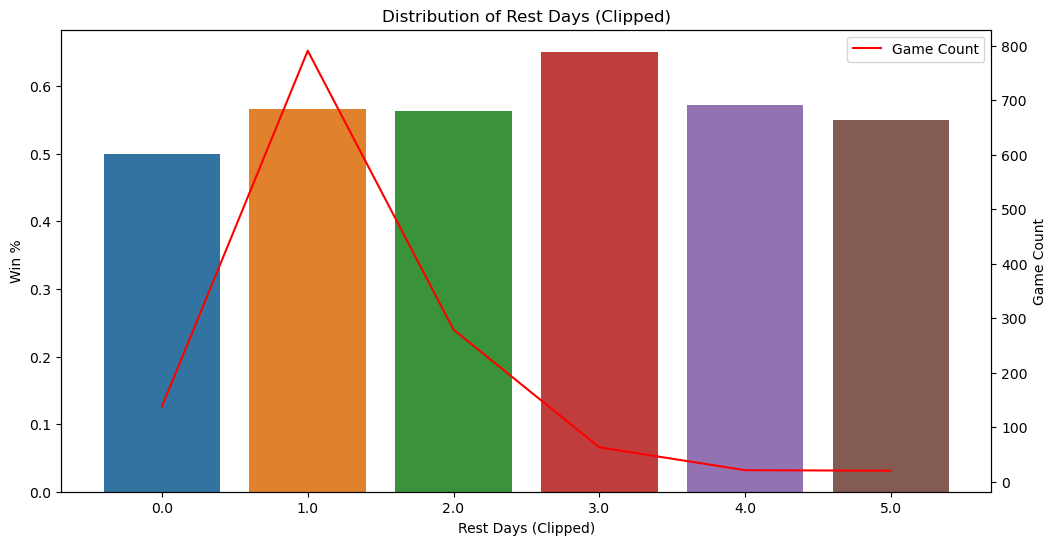

In [154]:
g = df.copy()
g = g[~g['is_away']]
g['rest_clipped'] = g['rest_days'].clip(0,5) # exclude super long breaks (all-star week)
win_pct = g.groupby('rest_clipped')['game_result'].apply(lambda s:(s=='win').mean()) # gets the win percentage for each group

counts = g['rest_clipped'].value_counts().sort_index()
display(counts) # counts the number of games in each group
# g = g.sort_values()
display(g)

print(sum(counts))


# plot
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x=win_pct.index, y=win_pct.values, ax=ax1)
plt.title('Distribution of Rest Days (Clipped)')
plt.xlabel('Rest Days (Clipped)')
plt.ylabel('Win %')
ax2 = ax1.twinx()
sns.lineplot(x=counts.index, y=counts.values, color='red', label='Game Count', ax=ax2)
ax2.set_ylabel('Game Count')
plt.show()


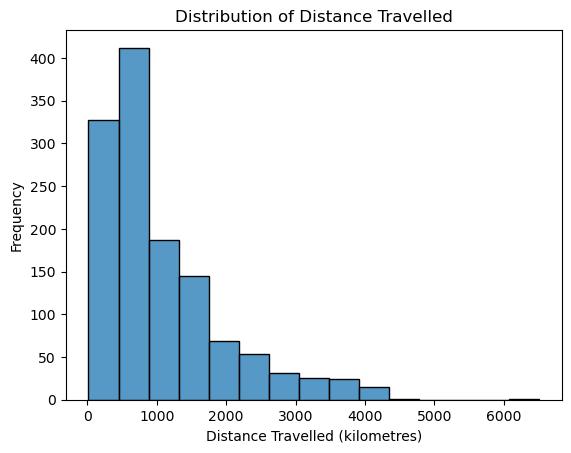

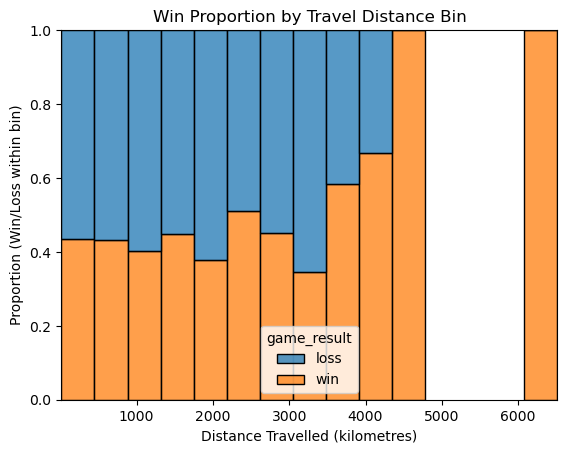

In [157]:
# analyze game wins vs. distance travelled
# get distribution of distance travelled

g = df.copy()
g = g[g['distance'] > 0] # remove rows where they do not travel (home games)
g = g[g['is_away']]
# create histogram of distances travelled
edges = np.histogram_bin_edges(g['distance'], bins=15)

sns.histplot(g['distance'], bins=edges)
plt.title('Distribution of Distance Travelled')
plt.xlabel('Distance Travelled (kilometres)')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data=g, x='distance', bins=edges, hue='game_result',
multiple='fill', stat='proportion')
plt.xlabel('Distance Travelled (kilometres)')
plt.ylabel('Proportion (Win/Loss within bin)')
plt.title('Win Proportion by Travel Distance Bin')
plt.show()


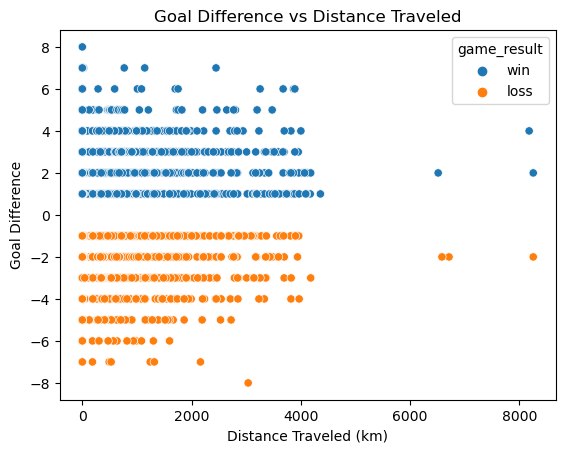

In [167]:
# scatter plot for goal difference and distance traveled
g = df.copy()
sns.scatterplot(x=g['distance'], y=g['goal_difference'], hue=g['game_result'])
plt.title('Goal Difference vs Distance Traveled')
plt.xlabel('Distance Traveled (km)')
plt.ylabel('Goal Difference')
plt.show()

,total_km,away_km,home_km,away_share,games,km_per_game
team,,,,,,
DAL,90091.216179,47821.013030,42270.203149,0.530807,82,1098.673368
FLA,82236.209404,50557.357409,31678.851995,0.614782,82,1002.880602
ANA,81436.186861,49745.793136,31690.393725,0.610856,82,993.124230
EDM,80360.990972,51512.810269,28848.180702,0.641018,82,980.012085
UTA,78319.423135,53910.919209,24408.503925,0.688347,82,955.114916
SEA,77495.029213,54502.082618,22992.946595,0.703298,82,945.061332
WPG,76265.260367,48551.009294,27714.251073,0.636607,82,930.064151
VGK,73787.170742,48576.499282,25210.671460,0.658333,82,899.843546
CGY,72626.900914,45204.494647,27422.406267,0.622421,82,885.693914


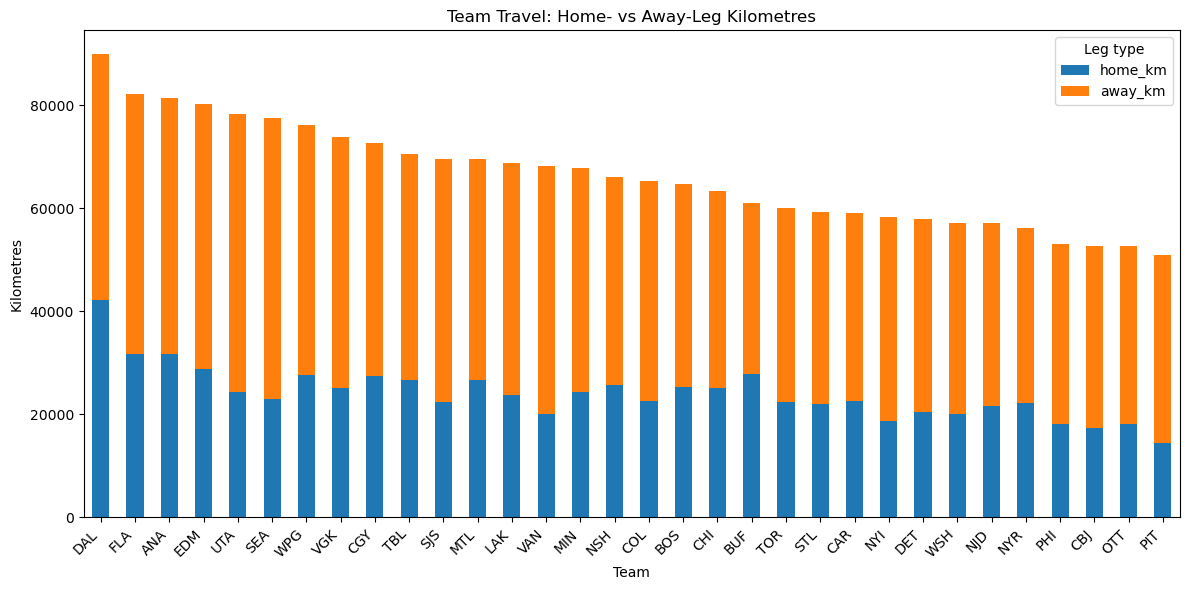

In [165]:
g = df.copy()
# g['is_away'] = g['is_away'].astype(str).str.upper().map({'TRUE': True, 'FALSE': False})

# Totals
total_km = g.groupby('team')['distance'].sum().rename('total_km')
away_km  = g[g['is_away']].groupby('team')['distance'].sum().rename('away_km')
home_km  = g[~g['is_away']].groupby('team')['distance'].sum().rename('home_km')

summary = pd.concat([total_km, away_km, home_km], axis=1).fillna(0)
summary['away_share']   = (summary['away_km'] / summary['total_km']).replace([np.inf, np.nan], 0)
summary['games']        = g.groupby('team')['game_id'].nunique()
summary['km_per_game']  = summary['total_km'] / summary['games']

# Sort by total travel (or pick 'away_km' to focus on road legs)
summary = summary.sort_values('total_km', ascending=False)

display(summary)

# Stacked bar: home vs away contributions to total
ax = summary[['home_km','away_km']].plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_title('Team Travel: Home- vs Away-Leg Kilometres')
ax.set_ylabel('Kilometres')
ax.set_xlabel('Team')
ax.legend(title='Leg type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Statistical test to determine if there is a cause and effect